# Project: Bayesian Analysis of Tropical Storms using Poisson Processes

In [1]:
# Create an activate a virtual environment, named `venv`
# !python3 -m venv .venv
# !source .venv/bin/activate

In [1]:
# Install the `pandas`, `numpy`, `matplotlib`, and `seaborn` Python libraries.
!pip install pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


## 1. Data Cleaning and Preprocessing

* Read in the `pacific.csv` dataset
* Handle missing data appropriately
* Convert data types as needed
* Create new features or transform existing ones if necessary
* Perform exploratory data analysis to understand distributions, relationships, outliers etc.

### 1.1. Data Loading and Initial Exploration

In [1]:
# # Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('pacific.csv')

# Display basic information about the dataset
print(df.info())

# Show the first few rows
print(df.head())

# Get summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26137 entries, 0 to 26136
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                26137 non-null  object
 1   Name              26137 non-null  object
 2   Date              26137 non-null  int64 
 3   Time              26137 non-null  int64 
 4   Event             26137 non-null  object
 5   Status            26137 non-null  object
 6   Latitude          26137 non-null  object
 7   Longitude         26137 non-null  object
 8   Maximum Wind      26137 non-null  int64 
 9   Minimum Pressure  26137 non-null  int64 
 10  Low Wind NE       26137 non-null  int64 
 11  Low Wind SE       26137 non-null  int64 
 12  Low Wind SW       26137 non-null  int64 
 13  Low Wind NW       26137 non-null  int64 
 14  Moderate Wind NE  26137 non-null  int64 
 15  Moderate Wind SE  26137 non-null  int64 
 16  Moderate Wind SW  26137 non-null  int64 
 17  Moderate Win

### 1.2. Data Cleaning and Preprocessing

This code performs data cleaning and preprocessing for a dataset containing information on Pacific storms. Below is a breakdown of its functionality:

1. **Time Formatting**:
   - The `pad_time` function adjusts the `Time` column entries to a consistent 4-digit format (`HHMM`) by adding leading zeros where necessary.
   - The `Time` column is then processed with this function, ensuring it is formatted as required.

2. **DateTime Conversion**:
   - Combines `Date` and `Time` columns into a new `DateTime` column, converting entries to datetime format (`YYYYMMDD HHMM`).
   - Errors in conversion are handled gracefully with `errors='coerce'`, converting invalid entries to `NaT`.

3. **Year Extraction**:
   - Extracts the year from `DateTime` and stores it in a new `Year` column, facilitating year-based analyses.

4. **Categorical Variable for Storm Status**:
   - Converts the `Status` column to a categorical variable (`StatusCategory`), allowing for efficient memory usage and easy categorization of storm statuses.

5. **Binary Variable for Hurricane Status**:
   - Creates a new binary column `IsHurricane`, where entries are `1` if the storm's status is "HU" (indicating a hurricane) and `0` otherwise.

6. **Wind Speed Conversion**:
   - Adds a new column `WindSpeedKMH` by converting `Maximum Wind` from knots to kilometers per hour using a factor of 1.852.

7. **Storm Count by Year**:
   - Groups data by `Year` and `ID` to calculate unique storm occurrences per year and outputs this summary.

8. **Error Checking for DateTime Conversion**:
   - Outputs rows where `DateTime` conversion failed, providing insight into any data inconsistencies.

This code effectively prepares the dataset for further analysis, with focus on time consistency, categorical encoding, binary classification, and unit conversion.


In [13]:
import pandas as pd
import numpy as np

# Load the data (assuming this step was done before)
# df = pd.read_csv('pacific.csv')

# Function to pad single-digit hours with a leading zero
def pad_time(time_str):
    if len(time_str) == 1:
        return f"0{time_str}00"
    elif len(time_str) == 3:
        return f"0{time_str}"
    return time_str

# Convert Date and Time columns to datetime
df['Time'] = df['Time'].astype(str).apply(pad_time)
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], format='%Y%m%d %H%M', errors='coerce')

# Extract year from DateTime
df['Year'] = df['DateTime'].dt.year

# Create a categorical variable for storm status
df['StatusCategory'] = pd.Categorical(df['Status'])

# Create a binary variable for hurricane status (1 if hurricane, 0 otherwise)
df['IsHurricane'] = (df['Status'] == 'HU').astype(int)

# Calculate wind speed in km/h
df['WindSpeedKMH'] = df['Maximum Wind'] * 1.852

# Group data by year and storm ID to get unique storms per year
storms_per_year = df.groupby(['Year', 'ID']).size().groupby('Year').size()

print(storms_per_year)

# Print any rows where DateTime conversion failed
print("\nRows with failed DateTime conversion:")
print(df[df['DateTime'].isna()][['Date', 'Time']])

Year
1949     6
1950     7
1951     9
1952     7
1953     4
        ..
2011    13
2012    17
2013    21
2014    23
2015    22
Length: 67, dtype: int64

Rows with failed DateTime conversion:
Empty DataFrame
Columns: [Date, Time]
Index: []


### 1.3. Exploratory Data Analysis

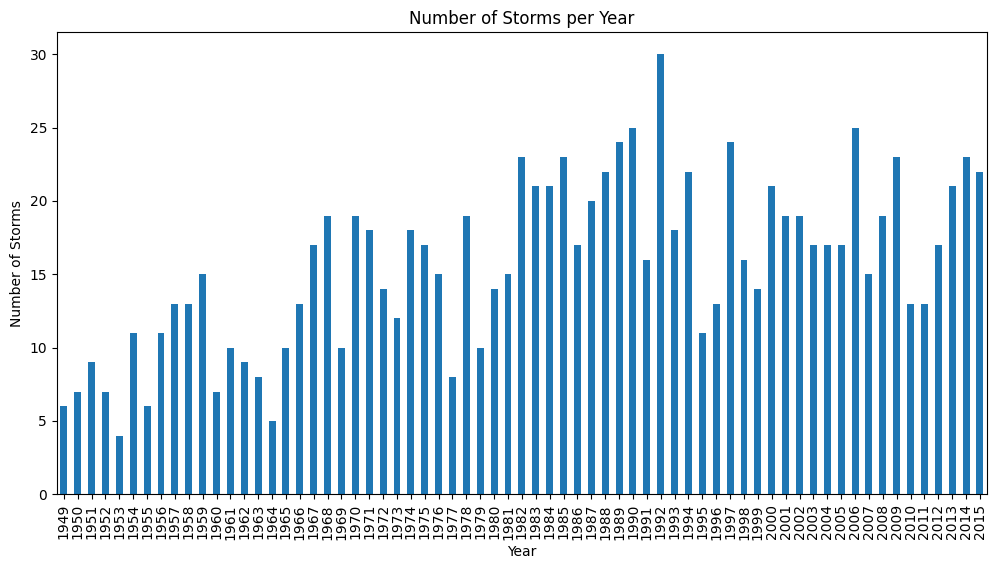

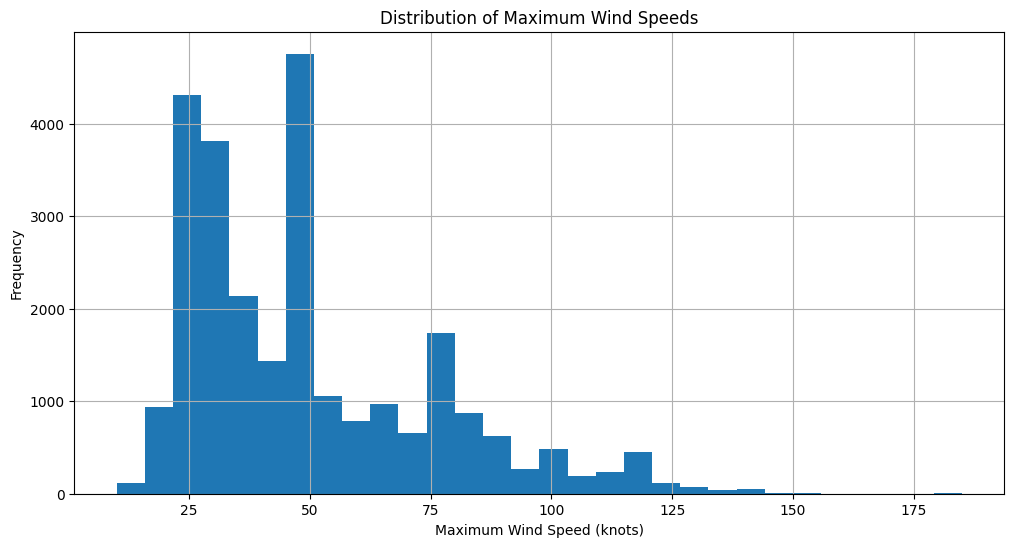

In [15]:
# Plot number of storms per year
plt.figure(figsize=(12, 6))
storms_per_year.plot(kind='bar')
plt.title('Number of Storms per Year')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.show()

# Plot distribution of maximum wind speeds
plt.figure(figsize=(12, 6))
df['Maximum Wind'].hist(bins=30)
plt.title('Distribution of Maximum Wind Speeds')
plt.xlabel('Maximum Wind Speed (knots)')
plt.ylabel('Frequency')
plt.show()


#### **Temporal Analysis (Top Image)**
The "Number of Storms per Year" plot reveals:

- Data coverage from approximately 1949 to 2015 (~66 years)
- Notable variations in storm frequency:
  - Minimum: ~5 storms per year (early years)
  - Maximum: ~30 storms (peak around 1990)
  - Average: roughly 15-20 storms annually
- Possible increasing trend in storm frequency over time
- Most recent years (2010-2015) showing relatively stable counts around 20-22 storms

#### **Wind Speed Distribution (Bottom Image)**
The "Distribution of Maximum Wind Speeds" histogram shows:

- Wind speeds measured in knots
- Multi-modal distribution with peaks at:
  - Major peak around 25-35 knots
  - Secondary peak around 50 knots
  - Smaller peak around 75-80 knots
- Long right tail extending to ~175 knots
- Most frequent wind speeds falling between 25-50 knots

## 2. Model Building and Initial MCMC

* Propose reasonable Bayesian models to describe the hurricane data generating process
* Use Poisson processes to model hurricane counts
* Incorporate relevant covariates like location, time, intensity metrics into models
* Set up MCMC algorithms to estimate posterior distributions of model parameters
* Run MCMC, check convergence and mixing, summarize posterior estimates

### 2.1. Poisson Process Model

The code below defines a Bayesian model for analyzing count data using a Poisson distribution with a Gamma prior. The main functions calculate the log-likelihood, log-prior, and log-posterior values of the Poisson model, which are essential for Bayesian inference.

1. **Log-Likelihood Calculation** (`poisson_log_likelihood`):
   - Computes the log-likelihood for observed data under a Poisson distribution, which is a common model for count data.
   - Takes `lambda_param` (the Poisson rate parameter) and observed data as inputs.
   - Outputs the log-likelihood, calculated as: $\sum( \text{data} \times \log(\lambda\text{\_param}) - \lambda\text{\_param} - \log(\text{factorial(data)}))$

2. **Log-Prior Calculation** (`poisson_prior`):
   - Computes the log-prior for `lambda_param` assuming a Gamma distribution, suitable for Bayesian inference due to its conjugacy with the Poisson model.
   - Parameters `alpha` and `beta` control the shape and rate of the Gamma prior.
   - The formula used is: $(\alpha - 1) \times \log(\lambda\text{\_param}) - \beta \times \lambda\text{\_param}$

3. **Log-Posterior Calculation** (`poisson_log_posterior`):
   - Calculates the log-posterior, which combines the log-likelihood and log-prior for Bayesian updating.
   - Uses the Poisson likelihood and Gamma prior, making this function essential for Bayesian parameter estimation.
   - Outputs the log-posterior by summing results from `poisson_log_likelihood` and `poisson_prior`.

These functions together enable estimation of the Poisson rate parameter, `lambda_param`, in a Bayesian context, useful in scenarios where count data is analyzed under a Poisson process.


In [3]:
def poisson_log_likelihood(lambda_param, data):
    """
    Calculate the log-likelihood of the Poisson distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    
    Returns:
    float: Log-likelihood value
    """
    return np.sum(data * np.log(lambda_param) - lambda_param - np.log(np.factorial(data)))

def poisson_prior(lambda_param, alpha=1, beta=1):
    """
    Calculate the log-prior of lambda using a Gamma distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    alpha (float): Shape parameter of the Gamma distribution
    beta (float): Rate parameter of the Gamma distribution
    
    Returns:
    float: Log-prior value
    """
    return (alpha - 1) * np.log(lambda_param) - beta * lambda_param

def poisson_log_posterior(lambda_param, data, alpha=1, beta=1):
    """
    Calculate the log-posterior of the Poisson model.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    alpha (float): Shape parameter of the Gamma prior
    beta (float): Rate parameter of the Gamma prior
    
    Returns:
    float: Log-posterior value
    """
    return poisson_log_likelihood(lambda_param, data) + poisson_prior(lambda_param, alpha, beta)

### 2.2. Metropolis-Hastings MCMC

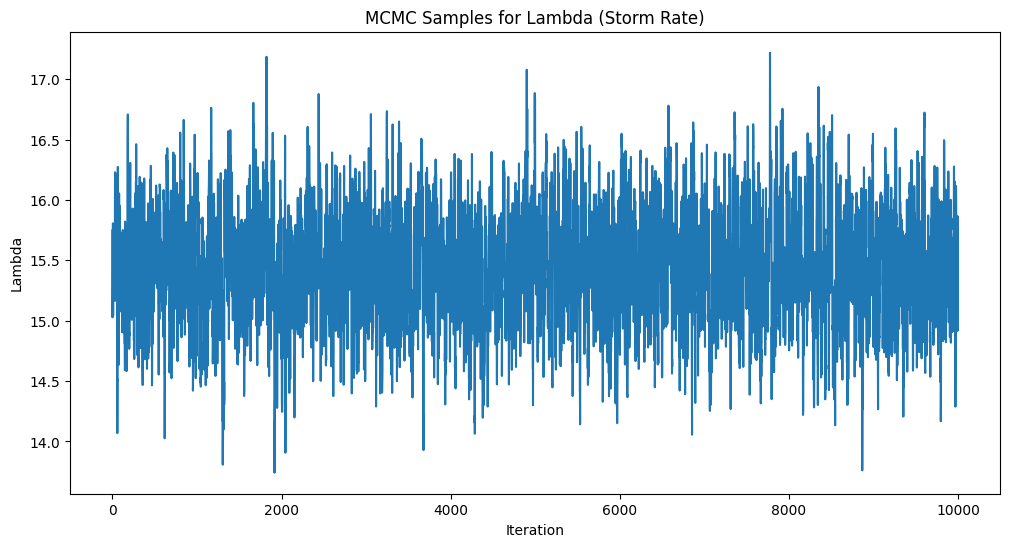

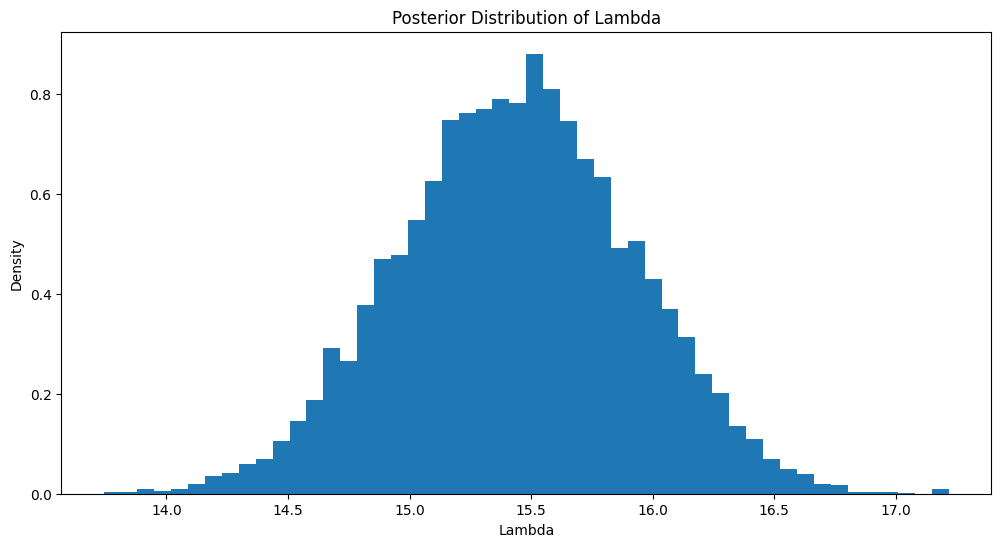

Posterior mean of lambda: 15.44
95% credible interval: (14.50, 16.37)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln, factorial

def poisson_log_likelihood(lambda_param, data):
    """
    Calculate the log-likelihood of the Poisson distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    
    Returns:
    float: Log-likelihood value
    """
    return np.sum(data * np.log(lambda_param) - lambda_param - gammaln(data + 1))

def poisson_prior(lambda_param, alpha=1, beta=1):
    """
    Calculate the log-prior of lambda using a Gamma distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    alpha (float): Shape parameter of the Gamma distribution
    beta (float): Rate parameter of the Gamma distribution
    
    Returns:
    float: Log-prior value
    """
    return (alpha - 1) * np.log(lambda_param) - beta * lambda_param

def poisson_log_posterior(lambda_param, data, alpha=1, beta=1):
    """
    Calculate the log-posterior of the Poisson model.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    alpha (float): Shape parameter of the Gamma prior
    beta (float): Rate parameter of the Gamma prior
    
    Returns:
    float: Log-posterior value
    """
    return poisson_log_likelihood(lambda_param, data) + poisson_prior(lambda_param, alpha, beta)

def metropolis_hastings(data, num_iterations, initial_lambda, proposal_std):
    """
    Perform Metropolis-Hastings MCMC for the Poisson model.
    
    Args:
    data (array-like): Observed data
    num_iterations (int): Number of MCMC iterations
    initial_lambda (float): Initial value for lambda
    proposal_std (float): Standard deviation for the proposal distribution
    
    Returns:
    array: Samples from the posterior distribution of lambda
    """
    current_lambda = initial_lambda
    samples = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        # Propose a new lambda
        proposed_lambda = np.abs(np.random.normal(current_lambda, proposal_std))
        
        # Calculate acceptance ratio
        current_log_posterior = poisson_log_posterior(current_lambda, data)
        proposed_log_posterior = poisson_log_posterior(proposed_lambda, data)
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        
        # Accept or reject the proposal
        if np.log(np.random.random()) < log_acceptance_ratio:
            current_lambda = proposed_lambda
        
        samples[i] = current_lambda
    
    return samples

# Assuming storms_per_year is already calculated
# Run MCMC
mcmc_samples = metropolis_hastings(storms_per_year.values, num_iterations=10000, 
                                   initial_lambda=np.mean(storms_per_year), proposal_std=0.5)

# Plot MCMC results
plt.figure(figsize=(12, 6))
plt.plot(mcmc_samples)
plt.title('MCMC Samples for Lambda (Storm Rate)')
plt.xlabel('Iteration')
plt.ylabel('Lambda')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(mcmc_samples, bins=50, density=True)
plt.title('Posterior Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.show()

# Calculate posterior mean and credible interval
posterior_mean = np.mean(mcmc_samples)
credible_interval = np.percentile(mcmc_samples, [2.5, 97.5])

print(f"Posterior mean of lambda: {posterior_mean:.2f}")
print(f"95% credible interval: ({credible_interval[0]:.2f}, {credible_interval[1]:.2f})")

#### **MCMC Sampling Results (Top Image)**
The trace plot shows 10,000 MCMC iterations with the following characteristics:
- Good mixing (fluctuates regularly around a central value)
- Reasonable convergence (no obvious trends or shifts)
- Values mostly ranging between 14.0 and 17.0
- A relatively stable mean around 15.5 storms per year

#### **Posterior Distribution (Bottom Image)**
The histogram shows the posterior distribution of $\lambda$ (i.e., storm rate) which appears:
- Approximately normal/Gaussian in shape
- Centered around 15.5 storms per year
- Relatively symmetric
- With most values falling between about 14.5 and 16.5 storms per year

## 3. Model Checking

* Use posterior predictive checks to assess model fit and assumptions
* Check if models can replicate important features of observed data
* Identify any systematic discrepancies between models and data
* Refine models based on model checking results

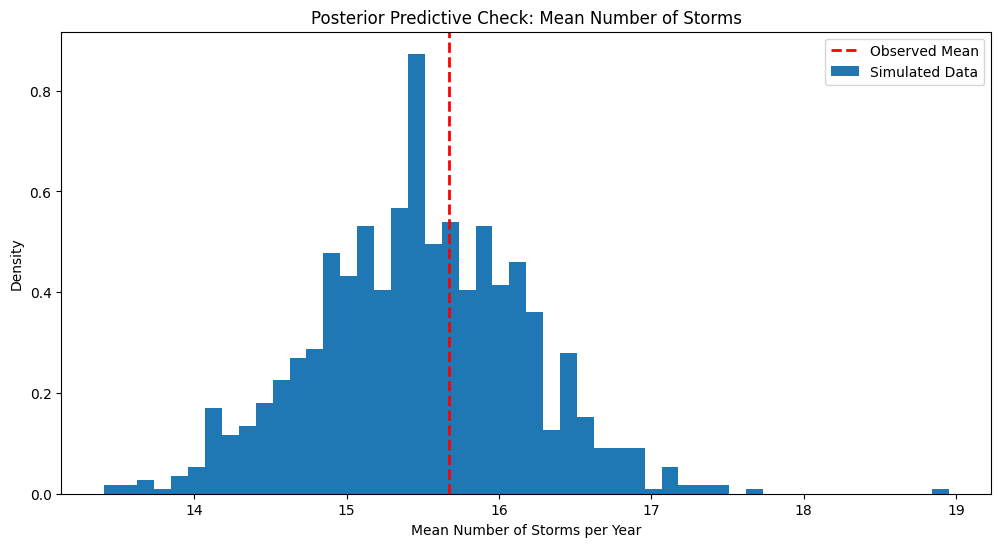

Posterior predictive p-value: 0.386


In [19]:
def simulate_poisson_data(lambda_param, num_years):
    """
    Simulate data from a Poisson process.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    num_years (int): Number of years to simulate
    
    Returns:
    array: Simulated data
    """
    return np.random.poisson(lambda_param, num_years)

# Posterior predictive check
num_simulations = 1000
simulated_data = np.array([simulate_poisson_data(np.random.choice(mcmc_samples), len(storms_per_year)) for _ in range(num_simulations)])

# Calculate test statistic (mean) for observed and simulated data
observed_mean = np.mean(storms_per_year)
simulated_means = np.mean(simulated_data, axis=1)

# Plot posterior predictive distribution
plt.figure(figsize=(12, 6))
plt.hist(simulated_means, bins=50, density=True)
plt.axvline(observed_mean, color='r', linestyle='dashed', linewidth=2)
plt.title('Posterior Predictive Check: Mean Number of Storms')
plt.xlabel('Mean Number of Storms per Year')
plt.ylabel('Density')
plt.legend(['Observed Mean', 'Simulated Data'])
plt.show()

# Calculate p-value
p_value = np.mean(simulated_means >= observed_mean)
print(f"Posterior predictive p-value: {p_value:.3f}")

## 4. Model Comparison

* Compare multiple candidate models
* Use cross-validation or information criteria (e.g. WAIC) for model comparison
* Identify models that balance fit and complexity
* Select final model(s) for inference and prediction

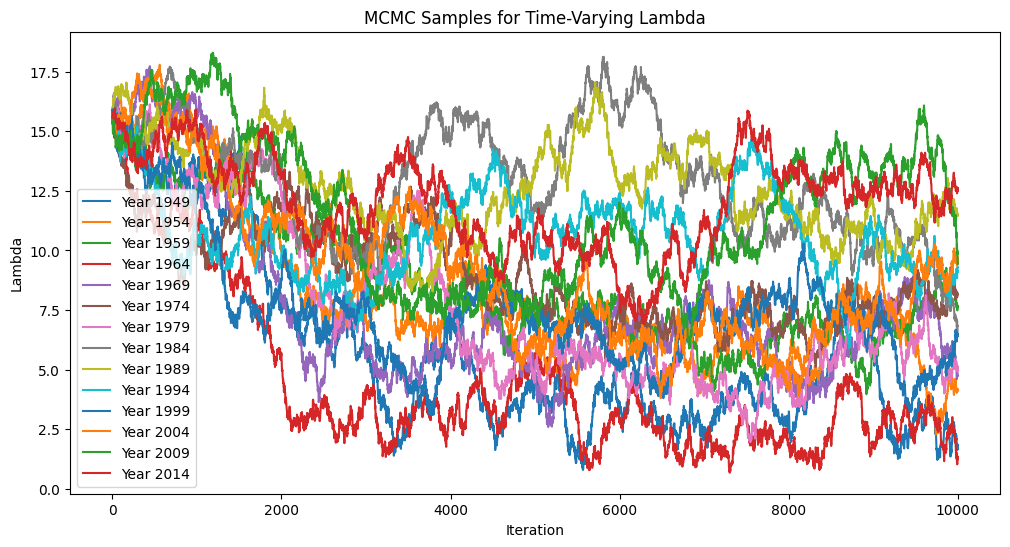

DIC for simple Poisson model: 455.25
DIC for time-varying Poisson model: 714.51


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

def poisson_log_likelihood(lambda_param, data):
    """
    Calculate the log-likelihood of the Poisson distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    
    Returns:
    float: Log-likelihood value
    """
    return np.sum(data * np.log(lambda_param) - lambda_param - gammaln(data + 1))

def poisson_prior(lambda_param, alpha=1, beta=1):
    """
    Calculate the log-prior of lambda using a Gamma distribution.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    alpha (float): Shape parameter of the Gamma distribution
    beta (float): Rate parameter of the Gamma distribution
    
    Returns:
    float: Log-prior value
    """
    return (alpha - 1) * np.log(lambda_param) - beta * lambda_param

def poisson_log_posterior(lambda_param, data, alpha=1, beta=1):
    """
    Calculate the log-posterior of the Poisson model.
    
    Args:
    lambda_param (float): Rate parameter of the Poisson distribution
    data (array-like): Observed data
    alpha (float): Shape parameter of the Gamma prior
    beta (float): Rate parameter of the Gamma prior
    
    Returns:
    float: Log-posterior value
    """
    return poisson_log_likelihood(lambda_param, data) + poisson_prior(lambda_param, alpha, beta)

def metropolis_hastings(data, num_iterations, initial_lambda, proposal_std):
    """
    Perform Metropolis-Hastings MCMC for the Poisson model.
    
    Args:
    data (array-like): Observed data
    num_iterations (int): Number of MCMC iterations
    initial_lambda (float): Initial value for lambda
    proposal_std (float): Standard deviation for the proposal distribution
    
    Returns:
    array: Samples from the posterior distribution of lambda
    """
    current_lambda = initial_lambda
    samples = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        # Propose a new lambda
        proposed_lambda = np.abs(np.random.normal(current_lambda, proposal_std))
        
        # Calculate acceptance ratio
        current_log_posterior = poisson_log_posterior(current_lambda, data)
        proposed_log_posterior = poisson_log_posterior(proposed_lambda, data)
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        
        # Accept or reject the proposal
        if np.log(np.random.random()) < log_acceptance_ratio:
            current_lambda = proposed_lambda
        
        samples[i] = current_lambda
    
    return samples

def time_varying_poisson_log_likelihood(lambda_params, data, years):
    """
    Calculate the log-likelihood of the time-varying Poisson model.
    
    Args:
    lambda_params (array): Rate parameters for each year
    data (array): Observed data
    years (array): Corresponding years for the data
    
    Returns:
    float: Log-likelihood value
    """
    return np.sum(data * np.log(lambda_params) - lambda_params - gammaln(data + 1))

def time_varying_poisson_prior(lambda_params, alpha=1, beta=1):
    """
    Calculate the log-prior for the time-varying Poisson model.
    
    Args:
    lambda_params (array): Rate parameters for each year
    alpha (float): Shape parameter of the Gamma distribution
    beta (float): Rate parameter of the Gamma distribution
    
    Returns:
    float: Log-prior value
    """
    return np.sum((alpha - 1) * np.log(lambda_params) - beta * lambda_params)

def time_varying_poisson_log_posterior(lambda_params, data, years, alpha=1, beta=1):
    """
    Calculate the log-posterior of the time-varying Poisson model.
    
    Args:
    lambda_params (array): Rate parameters for each year
    data (array): Observed data
    years (array): Corresponding years for the data
    alpha (float): Shape parameter of the Gamma prior
    beta (float): Rate parameter of the Gamma prior
    
    Returns:
    float: Log-posterior value
    """
    return time_varying_poisson_log_likelihood(lambda_params, data, years) + time_varying_poisson_prior(lambda_params, alpha, beta)

def metropolis_hastings_time_varying(data, years, num_iterations, initial_lambdas, proposal_std):
    """
    Perform Metropolis-Hastings MCMC for the time-varying Poisson model.
    
    Args:
    data (array): Observed data
    years (array): Corresponding years for the data
    num_iterations (int): Number of MCMC iterations
    initial_lambdas (array): Initial values for lambda parameters
    proposal_std (float): Standard deviation for the proposal distribution
    
    Returns:
    array: Samples from the posterior distribution of lambda parameters
    """
    current_lambdas = initial_lambdas
    samples = np.zeros((num_iterations, len(initial_lambdas)))
    
    for i in range(num_iterations):
        # Propose new lambdas
        proposed_lambdas = np.abs(np.random.normal(current_lambdas, proposal_std))
        
        # Calculate acceptance ratio
        current_log_posterior = time_varying_poisson_log_posterior(current_lambdas, data, years)
        proposed_log_posterior = time_varying_poisson_log_posterior(proposed_lambdas, data, years)
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        
        # Accept or reject the proposal
        if np.log(np.random.random()) < log_acceptance_ratio:
            current_lambdas = proposed_lambdas
        
        samples[i] = current_lambdas
    
    return samples

def calculate_dic(log_likelihood_func, params, data, years=None):
    """
    Calculate the Deviance Information Criterion (DIC).
    
    Args:
    log_likelihood_func (function): Log-likelihood function
    params (array): MCMC samples of parameters
    data (array): Observed data
    years (array, optional): Corresponding years for the data (for time-varying model)
    
    Returns:
    float: DIC value
    """
    if years is not None:
        log_likelihoods = np.apply_along_axis(lambda x: log_likelihood_func(x, data, years), 1, params)
    else:
        log_likelihoods = np.apply_along_axis(lambda x: log_likelihood_func(x, data), 1, params)
    
    d_bar = -2 * np.mean(log_likelihoods)
    
    if years is not None:
        d_hat = -2 * log_likelihood_func(np.mean(params, axis=0), data, years)
    else:
        d_hat = -2 * log_likelihood_func(np.mean(params, axis=0), data)
    
    p_d = d_bar - d_hat
    dic = d_hat + 2 * p_d
    return dic

# Assuming storms_per_year is already calculated
# Run MCMC for simple Poisson model
mcmc_samples = metropolis_hastings(storms_per_year.values, num_iterations=10000, initial_lambda=np.mean(storms_per_year), proposal_std=0.5)

# Run MCMC for time-varying model
initial_lambdas = np.full(len(storms_per_year), np.mean(storms_per_year))
mcmc_samples_time_varying = metropolis_hastings_time_varying(storms_per_year.values, storms_per_year.index, num_iterations=10000, initial_lambdas=initial_lambdas, proposal_std=0.1)

# Plot MCMC results for time-varying model
plt.figure(figsize=(12, 6))
for i in range(0, len(storms_per_year), 5):  # Plot every 5th year for clarity
    plt.plot(mcmc_samples_time_varying[:, i], label=f'Year {storms_per_year.index[i]}')
plt.title('MCMC Samples for Time-Varying Lambda')
plt.xlabel('Iteration')
plt.ylabel('Lambda')
plt.legend()
plt.show()

# Calculate DIC for simple Poisson model
dic_simple = calculate_dic(poisson_log_likelihood, mcmc_samples.reshape(-1, 1), storms_per_year.values)

# Calculate DIC for time-varying Poisson model
dic_time_varying = calculate_dic(time_varying_poisson_log_likelihood, mcmc_samples_time_varying, storms_per_year.values, storms_per_year.index)

print(f"DIC for simple Poisson model: {dic_simple:.2f}")
print(f"DIC for time-varying Poisson model: {dic_time_varying:.2f}")

## 5. Model Refinement

* Incorporate insights from model checking and comparison
* Test additional covariates, interaction terms, non-linear effects
* Consider more flexible model structures if needed
* Re-run MCMC for refined models and repeat model checking/comparison

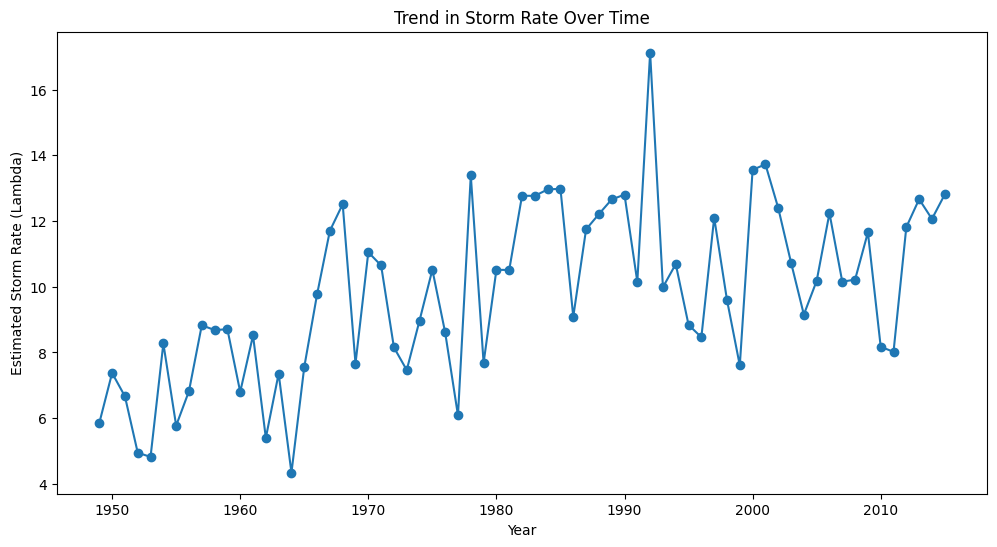

Linear trend slope: 0.0779
P-value for linear trend: 0.0000


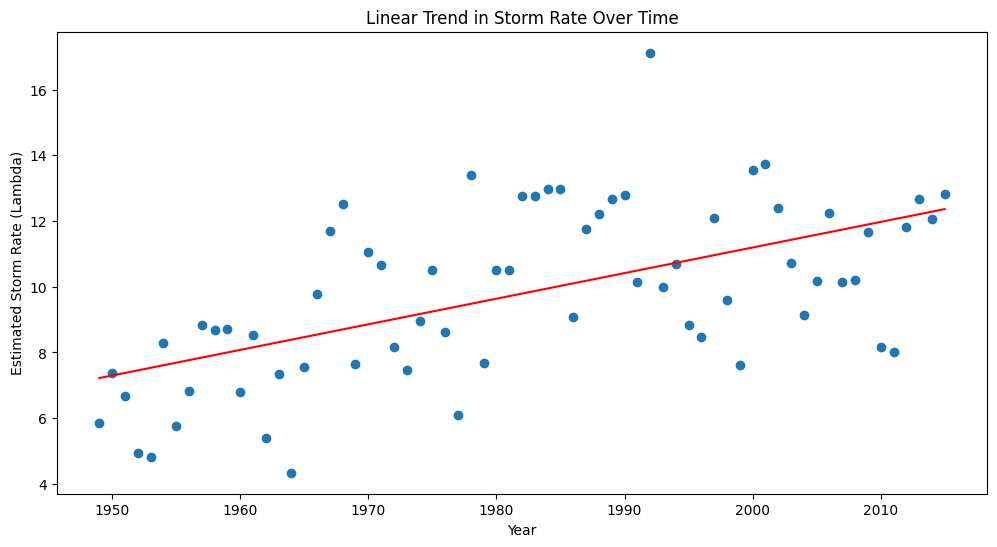

In [23]:
# Calculate posterior mean for each year
posterior_means = np.mean(mcmc_samples_time_varying, axis=0)

# Plot trend in storm rate
plt.figure(figsize=(12, 6))
plt.plot(storms_per_year.index, posterior_means, marker='o')
plt.title('Trend in Storm Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Estimated Storm Rate (Lambda)')
plt.show()

# Fit a linear trend to the posterior means
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(storms_per_year.index, posterior_means)

print(f"Linear trend slope: {slope:.4f}")
print(f"P-value for linear trend: {p_value:.4f}")

# Plot trend line
plt.figure(figsize=(12, 6))
plt.scatter(storms_per_year.index, posterior_means)
plt.plot(storms_per_year.index, intercept + slope * storms_per_year.index, color='r')
plt.title('Linear Trend in Storm Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Estimated Storm Rate (Lambda)')
plt.show()

## 6. Summarize Findings

* Describe the final selected model(s)
* Report key model parameters and their uncertainties
* Discuss goodness of fit and model assumptions
* Interpret covariate effects on hurricane patterns
* Quantify uncertainties in parameters and predictions